## Task 4:
1. Design a logic/algorithm to add a virtual background to the resulting car mask, while keeping the car grounded, for example, on a floor/white surface.
2. Bonus: Simulate a realistic shadow on the bottom of the car.
An example is shown below:


In [1]:
# !git clone https://github.com/xuebinqin/U-2-Net.git

Cloning into 'U-2-Net'...
remote: Enumerating objects: 1074, done.
remote: Counting objects: 100% (418/418), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 1074 (delta 396), reused 380 (delta 380), pack-reused 656
Receiving objects: 100% (1074/1074), 66.95 MiB | 3.48 MiB/s, done.
Resolving deltas: 100% (535/535), done.


In [4]:
# %cd U-2-Net

/home/ishant/Downloads/U-2-Net


In [1]:
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from data_loader import Rescale
from data_loader import RescaleT
from data_loader import RandomCrop
from data_loader import ToTensor
from data_loader import ToTensorLab
from model import U2NET
from model import U2NETP
from data_loader import SalObjDataset
from torch.autograd import Variable
from PIL import Image
from IPython.display import display



/home/ishant/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Add your model path and the image paths .....

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#u2net_bce1000a.pth
model_path = 'u2netp.pth'
image_path = "car1.jpg"
background_image_path= "b1.jpg"
model_pred = U2NETP(3, 1)
model_pred.load_state_dict(torch.load(model_path, map_location="cpu"))
model_pred.eval()

U2NETP(
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv3): REBNCONV(
      (conv_s1): Conv2d(16, 16, 

In [3]:
# transform
transform=transforms.Compose([
        RescaleT(320),
        ToTensorLab(flag=0)])

In [4]:
#Test Preprocesss
# test_salobj_dataset = SalObjDataset(img_name_list = image_path,
#                                         lbl_name_list = [],
#                                         transform=transforms.Compose([RescaleT(320),ToTensorLab(flag=0)]))

# def removeBack2(image_path):
#   for data_test in test_salobj_dataset:
#     input_test = data_test['image']
#     input_test = input_test.type(torch.FloatTensor)
#     if torch.cuda.is_available():
#       input_test = Variable(input_test.cuda())
#     else:
#       input_test = Variable(input_test)
#     d1,d2,d3,d4,d5,d6,d7= model_pred(input_test)

#         # normalization
#     pred = d1[:,0,:,:]
#     pred = norm_pred(pred)
#     predict = norm_pred(pred).squeeze().cpu().detach().numpy()
#     img_out = Image.fromarray(predict * 255).convert("RGB")
#     img_out = img_out.resize((input_test.size), resample=Image.BILINEAR)
#     empty_img = Image.new("RGBA", (input_test.size), 0)
#     img_out = Image.composite(input_test, empty_img, img_out.convert("L"))
#     del d1, pred, predict, inputs_test, sample

#     return img_out



In [5]:

def norm_pred(d):
    ma = torch.max(d)
    mi = torch.min(d)
    dn = (d - mi) / (ma - mi)
    return dn


#### Preprocess function is use to convert the image to the format of the U2Net


In [6]:

def preprocess(image):

    # use to create np zeros for the label ......
    label_3 = np.zeros(image.shape)
    label = np.zeros(label_3.shape[0:2])

    if 3 == len(label_3.shape):
        label = label_3[:, :, 0]
    elif 2 == len(label_3.shape):
        label = label_3

    if 3 == len(image.shape) and 2 == len(label.shape):
        label = label[:, :, np.newaxis]
    elif 2 == len(image.shape) and 2 == len(label.shape):
        image = image[:, :, np.newaxis]
        label = label[:, :, np.newaxis]

    transform = transforms.Compose([RescaleT(320), ToTensorLab(flag=0)])
    # transform to the U2Net format .....
    sample = transform({"imidx": np.array([0]), "image": image, "label": label})

    return sample


def remove_bg(image, resize=False):
    sample = preprocess(np.array(image))

    with torch.no_grad():
        inputs_test = torch.FloatTensor(sample["image"].unsqueeze(0).float())

        d1, _, _, _, _, _, _ = model_pred(inputs_test)
        pred = d1[:, 0, :, :]
        predict = norm_pred(pred).squeeze().cpu().detach().numpy()
        # predict convered to numpy and remove tensor
        img_out = Image.fromarray(predict * 255).convert("RGB")
        #scale up iamge to RGB
        img_out = img_out.resize((image.size), resample=Image.BILINEAR)
        # original size ....
        empty_img = Image.new("RGBA", (image.size), 0)
        img_out = Image.composite(image, empty_img, img_out.convert("L"))
        # remove the background.....
        del d1, pred, predict, inputs_test, sample

        return img_out


## Open and load image

In [50]:

# input_img = Image.open('/content/Fabric12.jpg').convert("RGBA")
input_img = Image.open('lma.png').convert("RGBA")


In [51]:
# Remove Background
img_pil = remove_bg(input_img)



/tmp/ipykernel_7041/1934366762.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img_out = img_out.resize((image.size), resample=Image.BILINEAR)


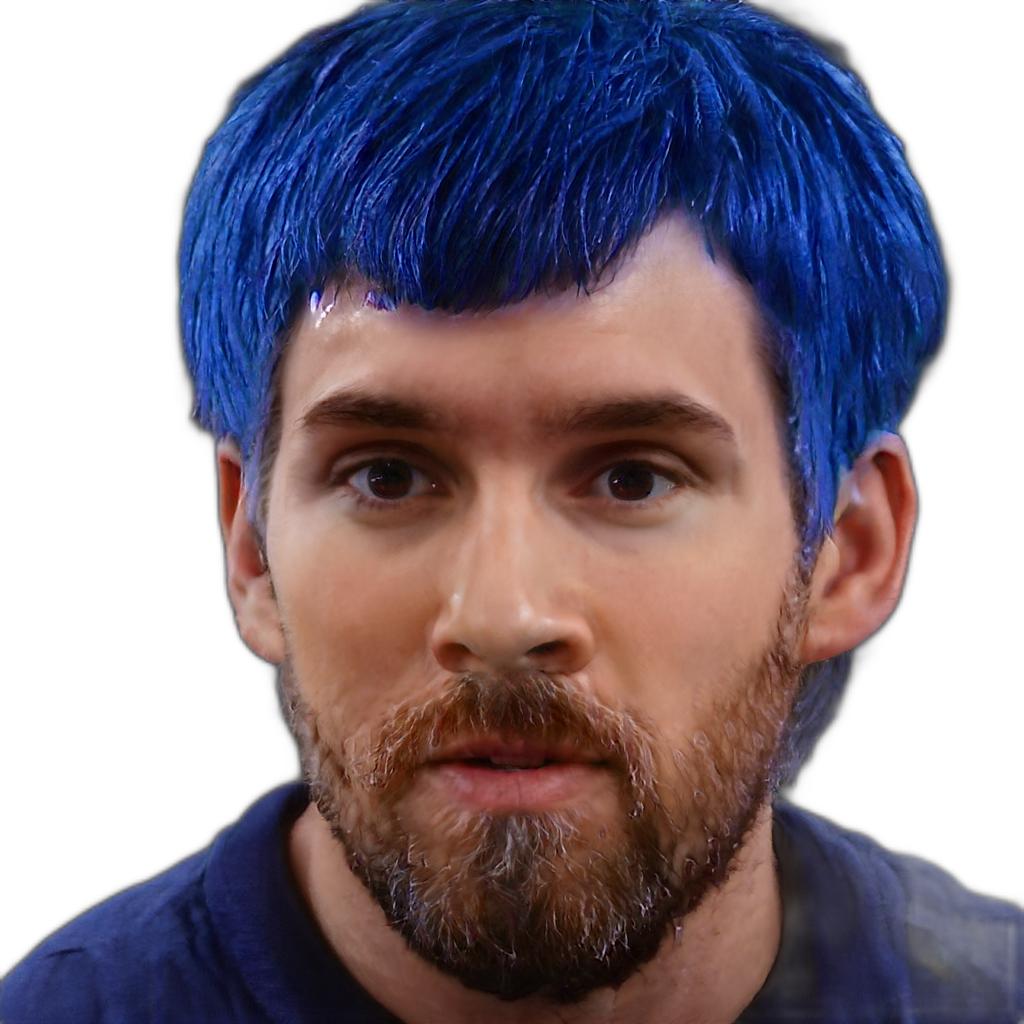

In [52]:
display(img_pil)

In [56]:
main_image = Image.open("m1.png")
removed_bg_image = img_pil.convert("RGBA")

# Resize the removed background image to fit the desired dimensions
removed_bg_image = removed_bg_image.resize((745 - 434, 335 - 45))

# Create a new image with the same dimensions as the main image
result_image = main_image.copy()

# Paste the resized removed background image onto the result image at the specified location
result_image.paste(removed_bg_image, (434, 20), removed_bg_image)

# Save the resulting image
result_image.save("lmA.png")